[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/adams/blob/master/demos/rnn/lstm_foundations.ipynb) 

# Long Short-Term Memory (LSTM)

Having looked into the computations within a RNN cell using numpy,  the previous demo equipped us with an understanding of recurrent computations. It turns out that RNNs have trouble learning long-term dependencies due to the vanishing gradient problem. Long short-term memory cells are designed to mitigate this problem and, together with GRUs, represent a state-of-the-art approach for sequential data. 

This demo splits into two parts. First, we revisit the LSTM cell architecture and the corresponding calculations. Using plain numpy for that purpose should give us a good idea of how things work. Thereafter, to prepare for building proper LSTMs in Keras, which we do in a [subsequent demo](https://colab.research.google.com/github/Humboldt-WI/adams/blob/master/demos/rnn/lstm_fin_forecasting.ipynb)), we discuss some peculiarities about LSTMs and their implementation in Keras. 

## LSTM Cell
The architecture of LSTM nodes can be daunting at first, so we will look at the pieces one by one. Here is a well-known picture from our favorite textbook.

<img src="lstm_3.svg" />

Source: Dive into Deep Learning http://d2l.ai/chapter_recurrent-modern/lstm.html

See the line that passes from state to state at the top with a plus in the middle? That's the hidden state and we see that the input information $x_t$ gets added to it after being processed in a more complex way. Imagine the hidden state is our long-term memory that stores information that may not be immediatly useful. 

Before information is added to the hidden state, the hidden state gets multiplied by the output of a sigmoid activated layer. We call this layer the **forget gate**, because it reduces some values of the hidden state by multiplying them with a value between 0 and 1.

The input that is added to the hidden state is processed in two steps, which make up the **input gate**. The tanh activated layer processes and transforms the information. Almost as in our RNN, although the input processing in our RNN did not use an activation after the input layer. The processed input is multiplied with another sigmoid activated layer, just like in the forget gate. And just like in the forget gate, the sigmoid layer here determines which parts of the processed input will be added to the hidden state and which will be forgotten.     

To the right, we see that the hidden state is passed on in two ways. On the upper level, it gets passed on as the hidden state. On the lower level, it is put through a tanh activation and filtered by yet another sigmoid layer. The result of this **output gate** passed on as the output at time step $t$ and passed on to be combined with the input of the next time step $t+1$. Image the output state that is passed on as our short-term memory.

### Step-by-step LSTM

Our LSTM is to process input data of the form $ X_t \in \mathbb{R} ^{n\times d}$, where $n$ is the size of the mini-batch and $d$ the input dimensions. We use the same settings as in the RNN demo and set $n=1, d=1$.

In [2]:
BATCH_SIZE = 1
INPUT_DIM = 1

We will further assume that the we are interested in predicting a scalar value such as the stock price one day ahead, and thus set the number of nodes in the output layer to one.

In [3]:
NO_OUTPUT_NODES = 1

For the number of nodes in the hidden state, we also consider the same setting of $h=5$ as in the RNN demo. 

In [4]:
NO_STATE_NODES = 5

With these settings, we can start with defining the data structures for our LSTM. These are the hidden state matrix $H_t \in \mathbb{R} ^{n\times h} $, the input gate $I_t \in \mathbb{R} ^{n\times h} $, the forget gate $F_t \in \mathbb{R} ^{n\times h} $, and the output gate $O_t \in \mathbb{R} ^{n\times h} $.
<br>
We also need a couple of weight matrices $W$ and biases $b$ to compute the values of the gates as follows:
$$ I_t = \sigma \left( X_t W_{xi} + H_{t-1}W_{hi} + b_i \right) $$
$$ F_t = \sigma \left( X_t W_{xf} + H_{t-1}W_{hf} + b_f \right) $$
$$ O_t = \sigma \left( X_t W_{xo} + H_{t-1}W_{ho} + b_o \right) $$
<br>
where $W_{xi}, W_{xf}, W_{xo} \in \mathbb{R} ^{d\times h}$ and $W_{hi}, W_{hf}, W_{ho} \in \mathbb{R} ^{h\times h}$ denote the weight matrices and $b_i, b_f, b_o \in \mathbb{R}^{1\times h}$ the biases. 

<br>In order to compute predictions from our LSTM, we need yet another set of parameters, $W_{hy} \in \mathbb{R}^{h\times c}$ and $b_{y} \in \mathbb{R}^{2\times c}$, where $c$ denotes the number of output units. The prediction equation, 
with $g(\cdot)$ denoting the output layer activation function, is then: 
$$Y_t = g \left( H_tW_{hy} + b_y\right) $$ 

Many parameters to initialize.  Let's go.

In [6]:
import numpy as np

# Define two anonymous functions to simplify the code
init_x = lambda: np.random.randn(INPUT_DIM, NO_STATE_NODES)
init_h = lambda: np.random.randn(NO_STATE_NODES, NO_STATE_NODES)

# Initialize weight matrices
W_xi, W_xf, W_xo = init_x(), init_x(), init_x() 
W_hi, W_hf, W_ho = init_h(), init_h(), init_h()

# Initialize biases
b_i = np.zeros(NO_STATE_NODES)
b_f = np.zeros(NO_STATE_NODES)
b_o = np.zeros(NO_STATE_NODES)

W_hy = np.random.randn(NO_STATE_NODES, NO_OUTPUT_NODES)
b_y = np.zeros(NO_OUTPUT_NODES)

# And finally we have the hidden state, which we initialize to zero
H = np.zeros(NO_STATE_NODES) # Since our hidden state gets update, we drop the 'index' t

Recall that the LSTM maintains a seperate cell memory, $C_t \in \mathbb{R}^{n\times h}$, in addition to the hidden state. We will also compute a candidate value of the new cell state, denoted by $\tilde{C_t}$. Finally, we need a new set of weights and biases to compute the new candidate memory as:
$$ \tilde{C}_t = tanH \left( X_tW_{xc} + H_{t-1}W_{hc} + b_c\right) $$

where $W_{xc} \in \mathbb{R}^{d \times h}, W_{hc} \in \mathbb{R}^{h \times h}, b_c  \in \mathbb{R}^{1 \times h}$. <br>
Here is the code to initialize the cell memory and its associated parameters.

In [7]:
# (Candidate) Cell memory
C_tilde = C =  np.zeros((BATCH_SIZE, NO_STATE_NODES))

# Parameters related to the cell memory
W_xc = np.random.randn(INPUT_DIM, NO_STATE_NODES)
W_hc = np.random.randn(NO_STATE_NODES, NO_STATE_NODES)
b_c = np.zeros(NO_STATE_NODES)

The actual processing is similar to the previous [RNN example](https://github.com/Humboldt-WI/adams/tree/master/demos/rnn/rnn_foundations.ipynb). To show this, the following cell re-creates the synthetic data set we were using for our RNN in the previous demo. 

In [32]:
#-----------------------------------------------------------
# Copy-pasted from the rnn_foundations notebook
#-----------------------------------------------------------
import pandas as pd
# load data
data = pd.read_csv('AMZN.csv')
data.set_index('Date', inplace=True)
# Compute returns
returns_series = data["Adj Close"].diff(periods=1).to_numpy().reshape([-1,1])
# Partitioning
train_size  = int(len(returns_series) * 0.80)
train, test = returns_series[:train_size], returns_series[train_size:]
# Scaling
from sklearn.preprocessing import MinMaxScaler
#Standardize the values to a range from zero to 1
scaler = MinMaxScaler()
train  = scaler.fit_transform(train)
test   = scaler.transform(test)

# Helper function to create AR structure (note that Panda's shift() or numpy's roll() function could be used to accelerate the calculations)
def create_dataset(time_series, window_size):
    """ Function to create data set with lagged response values for estimating an autoregressive model"""
    dataX, dataY = [], []
    
    for i in range(0,len(time_series) - window_size - 1):
        x = time_series[i:i + window_size] # Remember: x[a:b-1]
        dataX.append(x)
        y = time_series[i + window_size] # Remember: x[b]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY)

WINDOW_SIZE=22

X_train, y_train  = create_dataset(train, WINDOW_SIZE)
X_test, y_test   = create_dataset(test, WINDOW_SIZE)

#Reshape input to be [samples, time steps, features]
X_train  = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))
X_test   = np.reshape(X_test, (X_test.shape[0],X_test.shape[1], 1))

We begin with the first point in our input sequence, which is $X_{t-22}$ in our example, put it into our LSTM cell, perform all the internal computations to update our hidden state and the cell memory, and then proceed with the next point. So we first extract the minibatch of data.

In [33]:
minibatch = X_train[0:BATCH_SIZE,:,:].reshape([-1,22]) # reshaping as in the RNN case
minibatch

array([[       nan, 0.27370381, 0.28942156, 0.28371118, 0.27234689,
        0.259343  , 0.28167578, 0.28913885, 0.2686719 , 0.26363992,
        0.25917335, 0.28772543, 0.2778877 , 0.27065071, 0.2799796 ,
        0.27596536, 0.28133657, 0.29513198, 0.26578842, 0.26929379,
        0.25860797, 0.27749189]])

We then start with the first value and compute the gates.

In [34]:
X = minibatch[:,0:1]
X

array([[nan]])

#### Input gate
$ I_t = \sigma \left( X_t W_{xi} + H_{t-1}W_{hi} + b_i \right) $

In [36]:
from scipy.special import expit as sigmoid

I = sigmoid(np.dot(X, W_xi) + np.dot(H, W_hi) + b_i )
I

array([[nan, nan, nan, nan, nan]])

#### Forget gate
$ F_t = \sigma \left( X_t W_{xf} + H_{t-1}W_{hf} + b_f \right) $

In [37]:
F = sigmoid(np.dot(X, W_xf) + np.dot(H, W_hf) + b_f )
F

array([[nan, nan, nan, nan, nan]])

#### Output gate
$ O_t = \sigma \left( X_t W_{xo} + H_{t-1}W_{ho} + b_0 \right) $

In [38]:
O = sigmoid(np.dot(X, W_xo) + np.dot(H, W_ho) + b_o )
O

array([[nan, nan, nan, nan, nan]])

#### Cell state
Next, we can proceed with computing our new candidate memory: $ \tilde{C}_t = tanH \left( X_tW_{xc} + H_{t-1}W_{hc} + b_c\right) $, 

In [39]:
C_tilde = np.tanh(np.dot(X,W_xc) + np.dot(H,W_hc) + b_c)
C_tilde

array([[nan, nan, nan, nan, nan]])

which, in turn, allows us to update the cell memory according to: $C_t = F_t \odot C_{t-1} + I_t \odot \tilde{C}_t$

In [40]:
C = F * C + I * C_tilde
C

array([[nan, nan, nan, nan, nan]])

and finally our hidden state: $H_t = O_t \odot tanH \left(C_t \right)$

In [41]:
H = O * np.tanh(C)

We would proceed with repeating the process using the next elements of our input, that is time-lagged observations $x_{t-21}, x_{t-20}, ..., x_{t}$ and update the state of our LSTM cell, as represented by its memory and hidden state. At any point in time, we could make a prediction using the current hidden state.
#### Make a prediction

In [42]:
Yhat = np.dot(H, W_hy) + b_y
Yhat

array([[nan]])

This completes our journey through coding the forward pass in a LSTM "by hand". For comparison purpose, we could look at the next value in our time series to assess the previous prediction. 

In [43]:
minibatch
minibatch[:,1:2]

array([[0.27370381]])

Apparently, our prediction is pretty far off. That should not come as a surprise since we did not train our LSTM. 
Based on the prediction and the true value, we could apply our loss function, backpropagate the error and update the weights based on their negative gradient. 
Backpropagation for RNNs and LSTMs works exactly as backpropagation for other neural network architectures on the *unrolled* neural network graph (the one without the loop). It is not easy to work out on your own though. A step-by-step walkthrough is available on our blog if you are intersted https://humboldt-wi.github.io/blog/research/information_systems_1819/02lstmgruandbeyond/

### A note on notation
The notation we used for the LSTM follow the lecture slides and draws upon chapter 9.2 of [Dive into Deep Learning (D2L)](http://d2l.ai/chapter_recurrent-modern/lstm.html). When it comes to LSTM, [colah's blog post on Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is maybe the most famous source. I highly recommend reading the post, and when you do, please note that it uses a slightly different notation. Consider for example our input gate, which we defined as $ I_t = \sigma \left( X_t W_{xi} + H_{t-1}W_{hi} + b_i \right) $. Colah's blog defines the same gate as $ I_t = \sigma \left( W_i \left[ X_t, H_{t-1} \right] +b_i \right) $; same for other gates. Notation can be confusing when it differs across sources. Since Colah's blog is so popular, it is useful to see the equivalence between the two versions. The blog post assumes we concatenate the current input with the hidden state matrix of the previous step and then apply **one weight matrix** $W_i$. We, on the other hand, following D2L, consider **two weight matrices** $W_{xi}$ and $W_{hi}$ for the gates. You can easly convince yourself that both versions are equivalent. While writing down the mathematical notation is a bit tedious a little bit of numpy might just do the trick. 

In [44]:
# This is what we consider
W_xi
X
W_hi
H

array([[nan, nan, nan, nan, nan]])

In [45]:
# This is what Colah's blog considers
np.hstack((X, H))
np.vstack((W_xi, W_hi))

array([[ 0.91185717, -0.82777974, -1.53530328,  2.18516906, -1.07571311],
       [-1.15318561,  0.39309418, -0.94894074, -0.05277698,  1.15676662],
       [ 1.10273649, -0.91311492,  1.7057517 ,  0.50535371, -1.7855959 ],
       [-1.20352411,  1.02903543,  1.43188882,  0.46212581,  1.34001901],
       [-0.79696491,  1.02946739,  1.5338228 ,  1.54174453, -2.71035077],
       [ 0.47497536, -0.28324661,  1.3181224 , -0.06929086, -1.54099183]])

In [64]:
# And yes, it is the same
d2l = np.dot(X, W_xi) + np.dot(H, W_hi)
colah = np.dot(np.hstack((X, H)), np.vstack((W_xi, W_hi)))
d2l-colah

array([[-1.38777878e-17,  1.38777878e-17,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]])

## Concluding remarks and notes

### Notation
The notation we used for the LSTM follow the lecture slides and draws upon chapter 9.2 of [Dive into Deep Learning (D2L)](http://d2l.ai/chapter_recurrent-modern/lstm.html). When it comes to LSTM, [colah's blog post on Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is maybe the most famous source. I highly recommend reading the post, and when you do, please note that it uses a slightly different notation. Consider for example our input gate, which we defined as $ I_t = \sigma \left( X_t W_{xi} + H_{t-1}W_{hi} + b_i \right) $. Colah's blog defines the same gate as $ I_t = \sigma \left( W_i \left[ X_t, H_{t-1} \right] +b_i \right) $; same for other gates. Notation can be confusing when it differs across sources. Since Colah's blog is so popular, it is useful to see the equivalence between the two versions. The blog post assumes we concatenate the current input with the hidden state matrix of the previous step and then apply **one weight matrix** $W_i$. We, on the other hand, following D2L, consider **two weight matrices** $W_{xi}$ and $W_{hi}$ for the gates. You can easly convince yourself that both versions are equivalent. While writing down the mathematical notation is a bit tedious a little bit of numpy might just do the trick. 

In [62]:
# This is what we consider
W_xi
X
W_hi
H

array([[-0.09024775,  0.47879233,  0.16190862, -1.94446208,  0.47213937]])

array([[0.27370381]])

array([[-0.58085862, -0.0363312 ,  1.08331669,  1.19785893,  0.69495794],
       [ 1.63013443,  1.37963973,  1.00650678, -1.41765707, -1.09447956],
       [-0.93631225,  0.11963822, -0.0278419 , -0.36064368, -1.21106708],
       [ 1.75247636, -1.48884166,  0.47270972, -1.16958587, -0.05062323],
       [ 0.88035388, -1.58002961,  0.37723041, -0.76339754, -1.88443342]])

array([[ 0.07363884, -0.08464281, -0.08260762,  0.02893675,  0.02347467]])

In [63]:
# This is what Colah's blog considers
np.hstack((X, H))
np.vstack((W_xi, W_hi))

array([[ 0.27370381,  0.07363884, -0.08464281, -0.08260762,  0.02893675,
         0.02347467]])

array([[-0.09024775,  0.47879233,  0.16190862, -1.94446208,  0.47213937],
       [-0.58085862, -0.0363312 ,  1.08331669,  1.19785893,  0.69495794],
       [ 1.63013443,  1.37963973,  1.00650678, -1.41765707, -1.09447956],
       [-0.93631225,  0.11963822, -0.0278419 , -0.36064368, -1.21106708],
       [ 1.75247636, -1.48884166,  0.47270972, -1.16958587, -0.05062323],
       [ 0.88035388, -1.58002961,  0.37723041, -0.76339754, -1.88443342]])

In [64]:
# And yes, it is the same
d2l = np.dot(X, W_xi) + np.dot(H, W_hi)
colah = np.dot(np.hstack((X, H)), np.vstack((W_xi, W_hi)))
d2l-colah

array([[-1.38777878e-17,  1.38777878e-17,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]])

### Why Tanh activation?

The original RNN uses tanh rather than the - at that time typical - sigmoid activation, because the tanh gradient lies in [0;1] rather than [0; .25]. Increasing the values of the activation function derivatives helps mitigate the vanishing gradient problem for lower layers and helps control the size of values in the hidden state. 

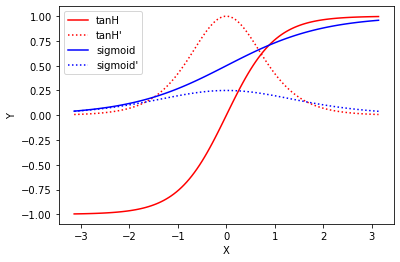

In [65]:
in_array = np.linspace(-np.pi, np.pi, 120) 

tan_h = np.tanh(in_array) 
sig = sigmoid(in_array)  
 
plt.plot(in_array, tan_h, color = 'red', label='tanH')
plt.plot(in_array, 1-tan_h**2, linestyle=':', color = 'red', label="tanH'")
plt.plot(in_array, sig, color = 'blue', label='sigmoid')
plt.plot(in_array, sig*(1-sig), linestyle=':', color = 'blue',  label="sigmoid'")
plt.xlabel("X") 
plt.ylabel("Y") 
plt.legend(loc='best')
plt.show();

# LSTM peculiarities

Having looked into the computations within a LSTM cell by writing numpy code in the previous part, our next task is to move on to Keras and build proper LSTMs. It turns out that this task is not quite as easy as when defining and training a feedforward network. Sequence data involves some additional challenges. The implementation of the LSTM in Keras also exhibits some peculiarities that we have to be aware of. 

The purpose of this part is to review some of the new challenges mentioned above and to provide some introductory content to help get you started. We will only briefly touch on selected concepts and revisit these in the next tutorial on [financial time series forecasting using an LSTM](https://colab.research.google.com/github/Humboldt-WI/adams/blob/master/demos/rnn/lstm_fin_forecasting.ipynb).

## Peculiarities #1: input/output

LSTMs are flexible in terms of the structure of the input and the output sequence. This picture from [A. Karpathy's blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) reminds us of the possibilities. 

<img src="RNN_structures.jpg" style="width: 800px;"/>
Source: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

Applications like:
1. Image recognition (binary outcome like cat/dog) - strictly speaking its not a sequence
2. Image captioning (outcome "Tall man in red shirt holds beer) - not really for Keras
3. Sentiment analysis, typing suggestions or our time series prediction (using a bunch of past values to predict one in the future)
4. Translation or also can be prediction of several steps in time series
5. May be used for example for ongoing video classification

Additionally, we have an architecture called **Bidirectional LSTM** that not only preserves information from the past and passes it to the future but also passes information from the future to the past (used widely for the tasks where context matters a lot).

## Peculiarities #2: train set structure
In the manual implementation, we have touched on how the data can be structured before feeding it into the model. Ultimately, we always want to have a set of features and a target. Although LSTMs are designed as models for sequential data, it turns out that they do not work well if the length of the input sequence is too long. As a rule of thumb, many sources mention a range of 200 - 400 time steps, which an LSTM can still process. When saying "can", you want to note that the quality of a predictive model can always be evaluated by measuring forecast accuracy. In addition to decreased accuracy, issues with too long sequences also concern the speed of training and the vanishing gradient problem. It is common practice to split a long sequence into subsequences and using the resulting "chunks of data" as input for the LSTM. This is the approach we adopted in the last tutorial. Remember this picture:

<img src="time_series_one_step.png" style="width: 500px;"/>

An important questions arises: what should be the length of the subsequence or time window? It will depend a lot on field knowledge. For example, in the case of sentiment analysis, the question is how many words you need on average to convey a sentiment. With ordinary time series, you can examine auto-correlation or partial auto-correlation to derive a judgment.

Next, relating the previous picture to the picture on possible LSTM setups, we note that we could also use a LSTM to forecast multiple steps ahead and not just one. This would look as follows:  

<img src="time_series_sequence.png" style="width: 500px;"/>

We decide on the sequence length and keep it constant. Our input and output sequences are now of the same length. Each new sequence starts one time step ahead of the sample sequence. The remaining values, i.e. the remainder of the full sequence length divided by the chosen length, are dropped. Keep in mind that then your model turns into seq2seq type. By making the network stateful, we use the hidden state at the end of the previous sequence as the starting point of the next sequence. Since the hidden state summarizes information from earlier observation, this increases the information available for each prediction beyond the window size. 

Last, note that a sequence learning task could also have an entirely different form of time series or text data. To illustrate this, let's say we are expecting the model to figure out that it has to count the number of ones in an input sequence and give it as prediction.

In this case, the order of those observations does not matter, although it is a sequence problem. We could shuffle the observations as we often do when working with non-sequential data, hoping that shuffling gives better generalization.

In any case, remember that Keras expects the input data for an LSTM to be a 3d tensor with dimensions:
- Number of samples or batch size
- Number of time steps
- Number of features

## Peculiarities #3: state
Keras supports two types of LSTMs: **stateful** or **stateless**

These terms are somewhat confusing. Isn't the very idea of RNNs and latent variable models to keep a hidden state in which information from processing past time steps accumulates? Of course it is. In Keras, the difference between a stateful and a stateless LSTM concerns the point when the hidden state is reset. The maybe more common case is a stateless LSTM. There, the hidden state is reset after processing one batch (see below for peculiarities wrt batches). 


Recall that longer time series are commonly split into chunks. This resetting approach enforces what we said above. The time window or length of a subsequence in which a longer time series is split is crucial. A *stateless* LSTM will not maintain state information across multiple batches. The information that you deem relevant to forecast must be included in the subsequence. 

*Stateful* LSTMs are Keras's solution toward maintaining state when working with longer sequences. Conceptually, *stateful* LSTM are conceptually more suitable for such settings. The splitting of the time series into chunks is somewhat arbitrary and done because not doing it would probably break LSTM training. You would not bother with splitting a time series into chunks when using an econometric model like ARIMA.   

Before demonstrating *stateful* and *stateless* LSTMs in the [next demo](https://colab.research.google.com/github/Humboldt-WI/adams/blob/master/demos/rnn/lstm_fin_forecasting.ipynb), let's note that a stateful recurrent model is one for which the internal states (memories) obtained after processing a batch of samples are reused as initial states for the samples of the next batch. This allows processing longer sequences while keeping computational complexity manageable. Again, the hidden state is passed from batch to batch, not within the batch. Within a batch the sub-sequences are treated as independent.

If the model is stateless, the cell states are reset after each batch. It is considered to be more efficient in implementations than stateful and the clear choice when every observation does not depend on the previous one (e.g., sentence classification). Additionally, stateless LSTMs can be implemented with and without shuffling of observations.


This [blog post](http://philipperemy.github.io/keras-stateful-lstm/) offers a very good explanation of stateful versus stateless and why the two are distinguished at all. It also offers a nice demo. Same more demos are available in [this tutorial](https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/).

## Peculiarities #4: batches 

When it comes to time series forecasting, there are many suggestions what should be the batch size for an LSTM. One of the rules one can observe is your batch size is the same as your output (according to Keras functionality). In case your output is next day prediction, you might want to consider batch size=1. More specifically, the Keras implementation enforces a constant batch size for training and prediction (see, e.g., [here for a discussion](https://stackoverflow.com/questions/43702481/why-does-keras-lstm-batch-size-used-for-prediction-have-to-be-the-same-as-fittin)). Thus, if you want to make prediction one day into the future, a common setting in stock prediction settings, then you should train your LSTM with batch size equal to one. Conversely, if you train your LSTM with batch size equal to, say, 10, you must provide exactly ten samples to the *.predict()* function. In practice, the latter implies that you would need to wait for ten days before you can make a prediction. I know this sounds very serious. Relax, there are ways to get round this issue. One is to use Tensorflow but you can [also *persuade* Keras to let you change the batch size from training to prediction].(https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/)  

In general, the advice is to keep batch size a value that divides without remainder into the train and validation set sizes, so that no data gets discarded. Keep in mind that the LSTM will be chaining together line 1 of batch n with line 1 of batch n+1 (see below). So try to keep the batch size somewhat meaningful. 

However, when it comes to text processing, the situation changes. [Jeremy Howard](https://www.youtube.com/watch?v=H3g26EVADgY&feature=youtu.be&t=17m50sin) advocates that splitting a big string of text into chunks, stacking it and then creating batches from the first "slice", second "slice" and etc. offers nice parallelization capacities and does not really harm the training process. Keep in mind that in case you have short sequences (that are still longer than your window size) this method might bring in additional distortion.

Example (mind that numbers are only used for simplicity, should rather be words: we have a "long" string [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17......1000]
Let's say we want to have batch=10, then we split the string into 10 chunks (that would make 100 numbers per chunk) and stack them:

[1.....100]

[101...200]

[201...300]

...

[900...1000]

(10 rows, 100 columns)

Now, if you remember in order to transform it into a supervised task we need to decide on the "window" size and the output type. Let's say we will go for a many-to-many architecture, so we choose the window=10 and same size output without overlap. 
Then our stack would look like this:

[1..10][11...20][21...30]......[91..100] 

[101..110][111...120][121...130]......[191..200]

.........

[901..910][911...920][921...930]......[991..1000]

That is [1..10] will be used to predict [2...11], [11...20] will be used to predict [12...21] and so forth.


Then, the first batch would be the first slice/column:

[1..10]

[101..110]

....

[901..910]


Second batch - second column and etc. where we use a stateful network to continue with the hidden state from the previous batch.

Structuring the data in this way, the sequence is lost at the end points of each row (i.e. 100 to 101, 200 to 201). If we consider the sequence to be not hundreds but thousands of words, that may be something we are willing to sacrifice, because we gain a parallelization of the process: the 10 chunks/rows are training simultaneously with every batch. 

## Peculiarities #5: Resetting ###
In case you are using a stateful LSTM, make sure you reset the state after every epoch, otherwise the NN will treat it as a continuation of the time series.
